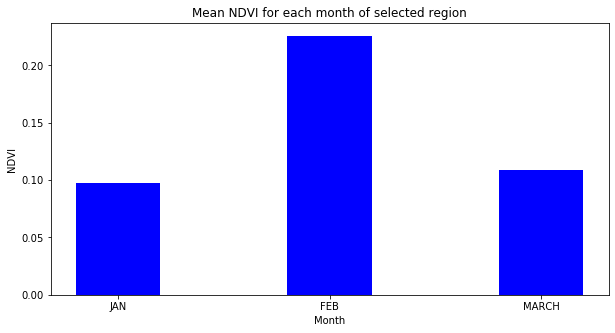

Map(center=[27.1029, 77.4813], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

In [2]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt

Map = geemap.Map()

imgcol = ee.ImageCollection("COPERNICUS/S2");

#Polygon Study area with coordinates
SA = ee.Geometry.Polygon(
        [[[77.44504111066439, 27.133452708222787],
          [77.44504111066439, 27.073245342079318],
          [77.5248636509476, 27.073245342079318],
          [77.5248636509476, 27.133452708222787]]], None, False);


spatialFiltered = imgcol.filterBounds(SA); #Filter by area, You can input either SA or rectangle here


#Enter Dates Here!
jancol = spatialFiltered.filterDate('2016-01-01', '2016-01-31'); #January
febcol = spatialFiltered.filterDate('2016-02-01', '2016-02-29'); #February
marchcol = spatialFiltered.filterDate('2016-03-01', '2016-03-31'); #March


#Cloud mask function
def maskS2clouds(image):
    qa = image.select('QA60');


    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;

    mask = qa.bitwiseAnd(cloudBitMask).eq(0) and (qa.bitwiseAnd(cirrusBitMask).eq(0));

    return image.updateMask(mask).divide(10000);



#Making cloud free images
cfreejan = jancol.map(maskS2clouds);
cfreesinglejan = cfreejan.median()
#print('cfreesinglejan',cfreesinglejan)

cfreefeb = febcol.map(maskS2clouds);
cfreesinglefeb = cfreefeb.median()
#print('cfreesinglefeb',cfreesinglefeb)

cfreemarch = marchcol.map(maskS2clouds);
cfreesinglemarch = cfreemarch.median()
#print('cfreesinglemarch',cfreesinglemarch)


#Calculating NDVIs for each month
ndvijan = cfreesinglejan.normalizedDifference(['B5', 'B4']).rename('NDVIjan');
ndvifeb = cfreesinglefeb.normalizedDifference(['B5', 'B4']).rename('NDVIfeb');
ndvimarch = cfreesinglemarch.normalizedDifference(['B5', 'B4']).rename('NDVImarch');


#Taking empty image instance and adding three NDVIs to it
ndvicomp = ee.Image().addBands([ndvijan, ndvifeb, ndvimarch]);


#-----------------------------------------------VISULISATION-------------------------------------------------------------
#Center map over Bharatpur area
Map.setCenter(77.4813,27.1029, 13);
scale = 30


#Simple RGB 
rgbVis = {'min': 0.0,'max': 0.3,'bands': ['B4', 'B3', 'B2'],'gamma': [0.95, 1.1, 1], 'scale':scale}
#Visulise Cloud free RGB image
Map.addLayer(cfreesinglemarch.clip(SA), rgbVis, 'RGB');


#NDVI of a month
ndviParams = {'min': 0, 'max': 0.2, 'palette': ['blue', 'white', 'green'], 'scale':scale};

#NDVI for january
Map.addLayer(ndvicomp.select('NDVIjan').clip(SA), ndviParams, 'NDVIJan');
#NDVI for february
Map.addLayer(ndvicomp.select('NDVIfeb').clip(SA), ndviParams, 'NDVIFeb');
#NDVI for march
Map.addLayer(ndvicomp.select('NDVImarch').clip(SA), ndviParams, 'NDVIMarch');


#False colour composite of a month
false = {'bands': ['B8', 'B4', 'B3'],'min': 0,'max': 0.5,'gamma': [0.95, 1.1, 1], 'scale':scale};


#Map.addLayer(cfreesinglejan.clip(SA), false, 'FCCJan')
#Map.addLayer(cfreesinglefeb.clip(SA), false, 'FCCFeb')
#Map.addLayer(cfreesinglemarch.clip(SA), false, 'FCCMarch')


#NDVI colour composite
ndvicc = {'bands': ['NDVIjan', 'NDVIfeb', 'NDVImarch'],'min': 0,'max': 0.5,'gamma': [0.85, 1.8, 0.8], 'scale':scale};

Map.addLayer(ndvicomp.clip(SA), ndvicc, 'NDVI Multitemporal')
Map


#-----------------------------------------------VISULISATION ENDS HERE---------------------------------------------------




#Calculating mean of each month
janmean = ndvicomp.select('NDVIjan').reduceRegion(reducer=ee.Reducer.mean(),geometry=SA,scale=scale);
febmean = ndvicomp.select('NDVIfeb').reduceRegion(reducer=ee.Reducer.mean(),geometry=SA,scale=scale);
marchmean = ndvicomp.select('NDVImarch').reduceRegion(reducer=ee.Reducer.mean(),geometry=SA,scale=scale);





# creating the data to plot
data = {'JAN':janmean.getInfo()['NDVIjan'], 'FEB':febmean.getInfo()['NDVIfeb'], 'MARCH':marchmean.getInfo()['NDVImarch']}
courses = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='blue',width = 0.4)
plt.xlabel("Month")
plt.ylabel("NDVI")
plt.title("Mean NDVI for each month of selected region")
plt.show()


Map



In [2]:
#Downloading the Data

import os
dscale = 30

out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')

#FCC for each month
#geemap.ee_export_image(cfreesinglejan.clip(SA), filename = os.path.join(out_dir, 'cloudfreejanfcc.tif'), scale=dscale, region=SA, file_per_band = False)
# geemap.ee_export_image(cfreesinglefeb.clip(SA), filename = os.path.join(out_dir, 'cloudfreefebfcc.tif'), scale=dscale, region=SA, file_per_band = False)
# geemap.ee_export_image(cfreesinglemarch.clip(SA), filename = os.path.join(out_dir, 'cloudfreemarchfcc.tif'), scale=dscale, region=SA, file_per_band = False)


#NDVI for each month
# geemap.ee_export_image(ndvicomp.select('NDVIjan').clip(SA), filename = os.path.join(out_dir, 'ndvijan.tif'), scale=dscale, region=SA, file_per_band = False)
# geemap.ee_export_image(ndvicomp.select('NDVIfeb').clip(SA), filename = os.path.join(out_dir, 'ndvifeb.tif'), scale=dscale, region=SA, file_per_band = False)
# geemap.ee_export_image(ndvicomp.select('NDVImarch').clip(SA), filename = os.path.join(out_dir, 'ndvimarch.tif'), scale=dscale, region=SA, file_per_band = False)

#NDVI Multitemporal
geemap.ee_export_image(ndvicomp.clip(SA), filename = os.path.join(out_dir, 'ndvimultitemporal.tif'), scale=dscale, region=SA, file_per_band = False)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\HArsh\Downloads\ndvimultitemporal.tif
